# Customization Tutorial

## Minor Adjustments

ModiFinder by default uses Modified Cosine for Alignment and MAGMa for Annotation but you can adjust these based on your needs. To do so, you can check the documentation for engines and look at the AlignmentEngine and the AnnotationEngine abstracts. If you don't want to develope a new engine and want to just modify the results slightly, you can change the values accordingly. Let's look at an example for the Annotation.

First, lets look at the unmodified result:

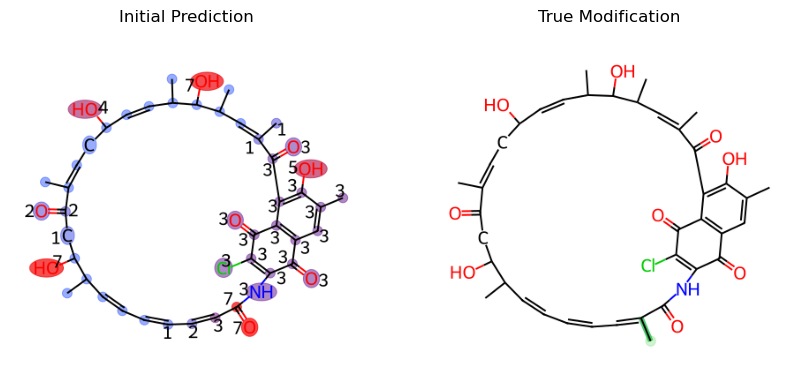

In [1]:

from modifinder import ModiFinder, Compound
from modifinder.utilities import visualizer as mf_vis
from matplotlib import pyplot as plt

c1 = "mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00011906190"
c2 = "mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00011906105"
args = {
    'mz_tolerance': 0.01,
    'ppm_tolerance': 40,
    'ratio_to_base_peak': 0.01,
    'normalize_peaks': True
}
known_compound = Compound(c1, id=c1, **args)
modified_compound = Compound(c2, id=c2, **args)

mf = ModiFinder(known_compound, modified_compound, **args)
initial_probs = mf.generate_probabilities()
initial_prediction = mf.draw_prediction(initial_probs, c1, show_legend=False, show_labels=True, shrink_labels=True)

true_modification = mf_vis.draw_modifications(known_compound.structure, modified_compound.structure, show_legend = False, 
                                              show_labels=True, shrink_labels=True, modification_only=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(initial_prediction)
ax[0].set_title("Initial Prediction")
ax[1].imshow(true_modification)
ax[1].set_title("True Modification")

for a in ax:
    a.axis('off')
plt.show()


This is an example discussed in the ModiFinder manuscript, for peaks 133.0653, 145.0649, and 147.0803, we want to remove any substructures that is not the result of the fragmentation at the amide bond as they are unlikely to happen.

First, lets check the fragmentations for the peak 133.0653


{2747705327616, 3296387399680, 1030792151103, 1023}


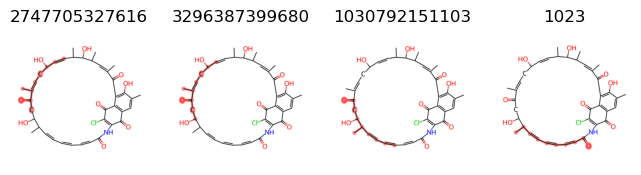

In [2]:

peak_indexes = known_compound.spectrum.get_peak_indexes(133.0653, **args)
# print(peak_indexes)
peak_index = peak_indexes[0]
fragments = known_compound.peak_fragments_map[peak_index]
images = []
for fragment in fragments:
    images.append((mf_vis.draw_frag_of_molecule(known_compound.structure, fragment), fragment))

fig, axs = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for ax, (image, fragment) in zip(axs, images):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(fragment)

print(fragments)


So we know we want to remove the following fragments: [2747705327616, 3296387399680, 1030792151103]

In [3]:
to_remove = [2747705327616, 3296387399680, 1030792151103]
known_compound.peak_fragments_map[peak_index] = set([fragment for fragment in fragments if fragment not in to_remove])

Lets do the same for peaks 145.0649, and 147.0803

peak_indexes [29]
{3297461141504, 549755814911}
peak_indexes [30]
{11269457313792, 3297461141504, 3294239916035, 1030792151167, 3281355014159, 3264175144991, 549755814911}


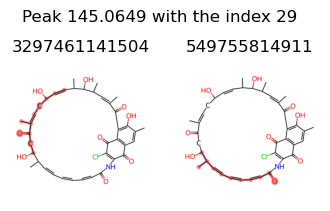

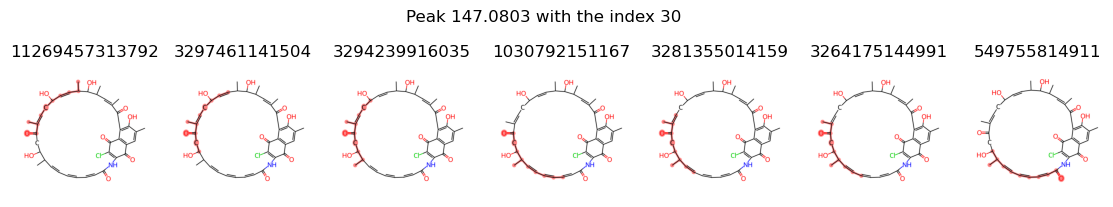

In [4]:
for value in [145.0649, 147.0803]:
    peak_indexes = known_compound.spectrum.get_peak_indexes(value, **args)
    print("peak_indexes", peak_indexes)
    peak_index = peak_indexes[0]
    fragments = known_compound.peak_fragments_map[peak_index]
    images = []
    for fragment in fragments:
        images.append((mf_vis.draw_frag_of_molecule(known_compound.structure, fragment), fragment))

    fig, axs = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
    for ax, (image, fragment) in zip(axs, images):
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(fragment)
    fig.suptitle(f'Peak {value} with the index {peak_index}', y = 1.1)
    print(fragments)

let's remove `3297461141504` from peak `29` and `11269457313792, 3297461141504, 3294239916035, 1030792151167, 3281355014159, 3264175144991` from peak 30

In [5]:

known_compound.peak_fragments_map[29] = set([fragment for fragment in known_compound.peak_fragments_map[29] if fragment not in [3297461141504]])
known_compound.peak_fragments_map[30] = set([fragment for fragment in known_compound.peak_fragments_map[30] if fragment not in [11269457313792, 3297461141504, 3294239916035, 1030792151167, 3281355014159, 3264175144991]])

Let's look at the new result after the adjustment of the peak to fragment map

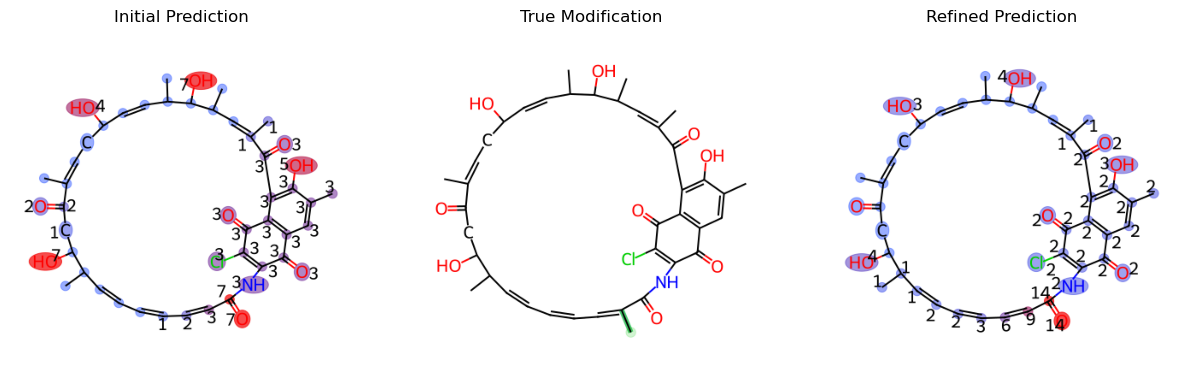

In [6]:
probs = mf.generate_probabilities()

refined_prediction = mf.draw_prediction(probs, c1, show_legend=False, show_labels=True, shrink_labels=True)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(initial_prediction)
ax[0].set_title("Initial Prediction")
ax[1].imshow(true_modification)
ax[1].set_title("True Modification")
ax[2].imshow(refined_prediction)
ax[2].set_title("Refined Prediction")
for a in ax:
    a.axis('off')
plt.show()

As you can see, the prediction result has improved much more and is now predicting with less proximity cover issue and less ambiguity cover issue.

## Customization with alignment engine and annotation engine

Here we show an example on how to use your alignment engine and your modification engine. Check the code for CosineAlignmentEngine and MAGMaAnnotationEngine for ideas. Here, we choose to use the default engines for demonstration but you can use your own custom implementations.

In [17]:
from modifinder.engines.alignment.CosineAlignmentEngine import CosineAlignmentEngine
from modifinder.engines.annotation.MAGMaAnnotationEngine import MAGMaAnnotationEngine
args = {
    'mz_tolerance': 0.01,
    'ppm_tolerance': 40,
    'ratio_to_base_peak': 0.01,
    'normalize_peaks': True
}


annotationEngine = MAGMaAnnotationEngine(breaks = 3, **args)
alignmentEngine = CosineAlignmentEngine(**args)



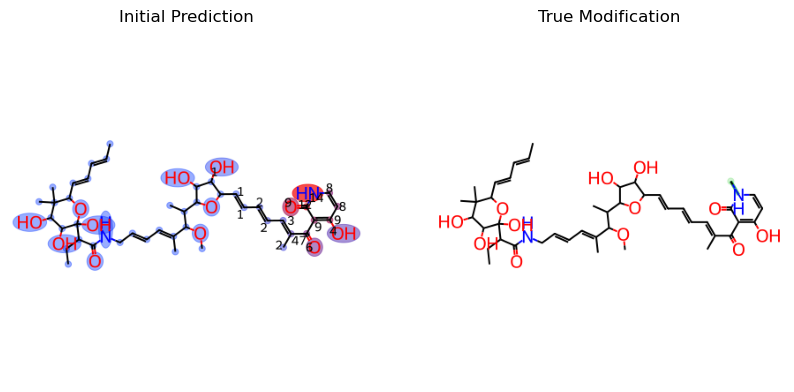

In [18]:

c1 = "mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00011906020"
c2 = "mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00011905978"

known_compound = Compound(c1, id=c1, **args)
modified_compound = Compound(c2, id=c2, **args)

mf = ModiFinder(known_compound, modified_compound, annotationEngine=annotationEngine, alignmentEngine=alignmentEngine, **args)
initial_probs = mf.generate_probabilities()

initial_prediction = mf.draw_prediction(initial_probs, c1, show_legend=False, show_labels=True, shrink_labels=True, annotation_scale=0.7)

true_modification = mf_vis.draw_modifications(known_compound.structure, modified_compound.structure, show_legend = False, 
                                              show_labels=True, shrink_labels=True, modification_only=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(initial_prediction)
ax[0].set_title("Initial Prediction")
ax[1].imshow(true_modification)
ax[1].set_title("True Modification")

for a in ax:
    a.axis('off')
plt.show()